# 一目均衡表のデモ

In [1]:
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
symbol = '9983.T'
end_date = datetime.today()
start_date = end_date - timedelta(days=730)
# yahooサイトからデータをダウンロード
data = yf.download(symbol, start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


In [3]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-08-15,28213.333984,28540.000000,28146.666016,28390.000000,27888.498047,1475400
2022-08-16,28433.333984,28623.333984,28283.333984,28576.666016,28071.871094,1493400
2022-08-17,28666.666016,29410.000000,28656.666016,29376.666016,28857.736328,2566800
2022-08-18,29113.333984,29200.000000,28876.666016,28876.666016,28366.570312,1887900
2022-08-19,28913.333984,29146.666016,28423.333984,28516.666016,28012.929688,1713300


In [4]:
df = data.reset_index().drop(columns='Close').rename(columns={'Date':'timestamp', 'Open':'open', \
                        'High':'high', 'Low':'low', 'Adj Close':'close', 'Volume':'volume'})

In [5]:
df.head()

,timestamp,open,high,low,close,volume
0,2022-08-15,28213.333984,28540.000000,28146.666016,27888.498047,1475400
1,2022-08-16,28433.333984,28623.333984,28283.333984,28071.871094,1493400
2,2022-08-17,28666.666016,29410.000000,28656.666016,28857.736328,2566800
3,2022-08-18,29113.333984,29200.000000,28876.666016,28366.570312,1887900
4,2022-08-19,28913.333984,29146.666016,28423.333984,28012.929688,1713300


In [6]:
# Calculate the Ichimoku indicators
df['tenkan_sen'] = (df['high'].rolling(window=9).max() + df['low'].rolling(window=9).min()) / 2
df['kijun_sen'] = (df['high'].rolling(window=26).max() + df['low'].rolling(window=26).min()) / 2
df['senkou_span_1'] = (df['tenkan_sen'] + df['kijun_sen']) / 2
df['senkou_span_a'] = df['senkou_span_1'].shift(26)
df['senkou_span_2'] = (df['high'].rolling(window=52).max() + df['low'].rolling(window=52).min()) / 2
df['senkou_span_b'] = df['senkou_span_2'].shift(26)
df['chikou_span'] = df['close'].shift(-26)

# Calculate the Cloud (Kumo)
df['cloud_top'] = df[['senkou_span_1','senkou_span_2']].max(axis=1)
df['cloud_bottom'] = df[['senkou_span_1','senkou_span_2']].min(axis=1)

# Calculate the 14 EMA
df['ema'] = df['close'].ewm(span=14).mean()

In [7]:
# Create the signals, Create buy and sell signals column for the Ichimoku strategy
# 好転＝買い, 逆転＝売り, とした場合
signal_conditions = [
    ((df['tenkan_sen'] > df['kijun_sen']) & (df['kijun_sen'] > df['kijun_sen'].shift(1))) ,
    ((df['tenkan_sen'] < df['kijun_sen']) & (df['kijun_sen'] < df['kijun_sen'].shift(1))) ,
]
signal_choices = [1, -1]

df['signal'] = np.select(signal_conditions, signal_choices, default=0)

# remove the look ahead bias by creating a signal lag of one period
df['signal'] = df['signal'].shift(1)

In [8]:
# Initialize the strategy performance variables
initial_capital = 100
capital = initial_capital
profit = 0

# Keep track of the previous signal
prev_signal = df.loc[0, 'signal']

# Previous close prise
prev_close = df.loc[0, 'close']

In [9]:
# Backtest the strategy
for i in range(1, len(df)):
    current_signal = df.loc[i, 'signal']
    if current_signal != prev_signal:
        if current_signal == 1:
            # Buy signal
            profit = capital * (df.loc[i, 'close'] - prev_close) / prev_close
            capital += profit

        elif current_signal == -1:
            # Sell signal
            profit = capital * (prev_close - df.loc[i, 'close']) / df.loc[i, 'close']
            capital += profit
        
        prev_close = df.loc[i, 'close']
            
    # Update the previous signal
    prev_signal = current_signal

    # print(f'{i} | current Signal: {current_signal} | Previous Signal: {prev_signal} | Capital: ${capital} | Profit: ${profit} | Prev_close: {prev_close}')

In [10]:
# Create the Positions
conditions = [
    (df['signal'] == 1) & (df['signal'] != df['signal'].shift(1)),
    (df['signal'] == -1) & (df['signal'] != df['signal'].shift(1))
]

choices = [1, -1]

df['positions'] = np.select(conditions, choices, default=np.nan)

In [11]:
# Print the strategy performance
print(df.tail(15))
overall_profit = capital - initial_capital
pl_percentage = (capital - initial_capital) / initial_capital * 100
print(f'Initial capital: {initial_capital} USDT')
print(f'Final capital: {capital} USDT')
print(f'Overall Profit: {overall_profit:.2f} USDT')
print(f'Percentage Profit Gain: {pl_percentage:.2f}%')

     timestamp     open     high      low    close   volume  tenkan_sen  \
475 2024-07-22  41600.0  41750.0  41240.0  41590.0   903700     43290.0   
476 2024-07-23  41770.0  41880.0  41280.0  41320.0   712100     43290.0   
477 2024-07-24  40820.0  41370.0  40630.0  40980.0   962200     42985.0   
478 2024-07-25  40250.0  40560.0  40050.0  40130.0  1590600     42245.0   
479 2024-07-26  40550.0  41120.0  40380.0  40850.0  1668400     41525.0   
480 2024-07-29  41200.0  41800.0  40830.0  41160.0  1190200     41420.0   
481 2024-07-30  40530.0  40940.0  40060.0  40940.0  1396200     41220.0   
482 2024-07-31  40550.0  42090.0  40500.0  41650.0  1969700     41070.0   
483 2024-08-01  40980.0  41100.0  39790.0  41100.0  1992500     40940.0   
484 2024-08-02  39850.0  41080.0  39850.0  40340.0  2784800     40940.0   
485 2024-08-05  39640.0  40080.0  35140.0  36470.0  3144500     38615.0   
486 2024-08-06  39210.0  39660.0  36710.0  39320.0  4001900     38615.0   
487 2024-08-07  37220.0  

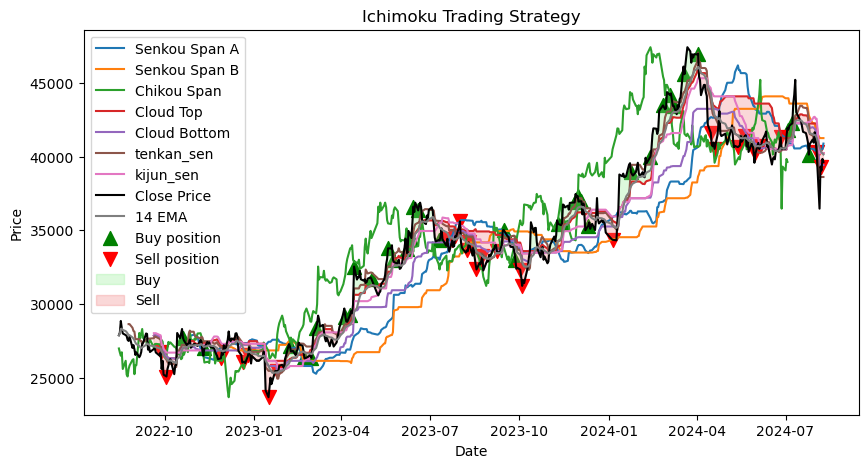

In [12]:
# Plot the Ichimoku strategy and the close price
plt.figure(figsize=(10, 5))
plt.plot(df['timestamp'], df['senkou_span_a'], label='Senkou Span A')
plt.plot(df['timestamp'], df['senkou_span_b'], label='Senkou Span B')
plt.plot(df['timestamp'], df['chikou_span'], label='Chikou Span')
plt.plot(df['timestamp'], df['cloud_top'], label='Cloud Top')
plt.plot(df['timestamp'], df['cloud_bottom'], label='Cloud Bottom')
plt.plot(df['timestamp'], df['tenkan_sen'], label='tenkan_sen')
plt.plot(df['timestamp'], df['kijun_sen'], label='kijun_sen')
plt.plot(df['timestamp'], df['close'], label='Close Price', color='black')

# Plot the 14 EMA
plt.plot(df['timestamp'], df['ema'], label='14 EMA')

# Plot the positions
plt.scatter(df['timestamp'][df['positions'] == 1], df['close']
            [df['positions'] == 1], color='green', label='Buy position', marker="^", s=100)
plt.scatter(df['timestamp'][df['positions'] == -1], df['close']
            [df['positions'] == -1], color='red', label='Sell position', marker="v", s=100)

# Fill area under close line for cloud top
plt.fill_between(df['timestamp'], df['close'], df['cloud_top'] , where=(df['close'] > df['cloud_top']),
                 color='lightgreen', alpha=0.3, label='Buy')

# Fill area under close line for cloud top
plt.fill_between(df['timestamp'], df['close'], df['cloud_top'], where=(df['close'] < df['cloud_top']),
                 color='lightcoral', alpha=0.3, label='Sell')

plt.legend()

# Add axis labels and a title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Ichimoku Trading Strategy')

# Show the plot
plt.show()

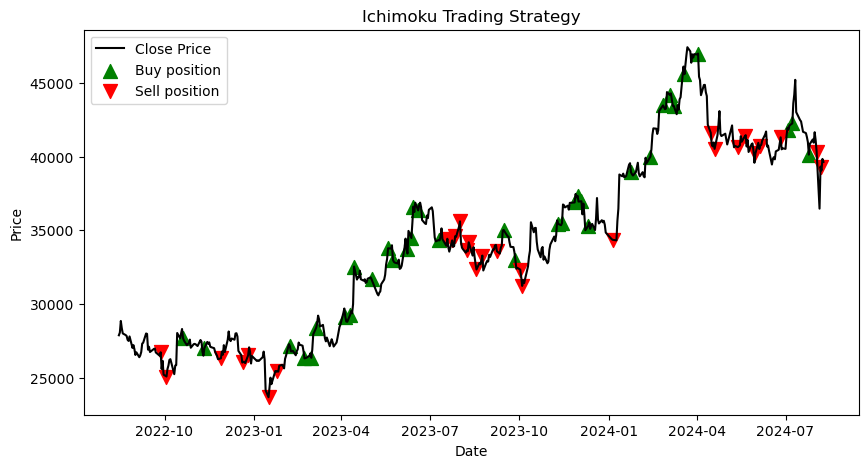

In [14]:
# Plot the Ichimoku strategy and the close price
plt.figure(figsize=(10, 5))
#plt.plot(df['timestamp'], df['senkou_span_a'], label='Senkou Span A')
#plt.plot(df['timestamp'], df['senkou_span_b'], label='Senkou Span B')
#plt.plot(df['timestamp'], df['chikou_span'], label='Chikou Span')
#plt.plot(df['timestamp'], df['cloud_top'], label='Cloud Top')
#plt.plot(df['timestamp'], df['cloud_bottom'], label='Cloud Bottom')
#plt.plot(df['timestamp'], df['tenkan_sen'], label='tenkan_sen')
#plt.plot(df['timestamp'], df['kijun_sen'], label='kijun_sen')
plt.plot(df['timestamp'], df['close'], label='Close Price', color='black')

# Plot the 14 EMA
#plt.plot(df['timestamp'], df['ema'], label='14 EMA')

# Plot the positions
plt.scatter(df['timestamp'][df['positions'] == 1], df['close']
            [df['positions'] == 1], color='green', label='Buy position', marker="^", s=100)
plt.scatter(df['timestamp'][df['positions'] == -1], df['close']
            [df['positions'] == -1], color='red', label='Sell position', marker="v", s=100)

# Fill area under close line for cloud top
#plt.fill_between(df['timestamp'], df['close'], df['cloud_top'] , where=(df['close'] > df['cloud_top']),
#                 color='lightgreen', alpha=0.3, label='Buy')

# Fill area under close line for cloud top
#plt.fill_between(df['timestamp'], df['close'], df['cloud_top'], where=(df['close'] < df['cloud_top']),
#                 color='lightcoral', alpha=0.3, label='Sell')

plt.legend()

# Add axis labels and a title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Ichimoku Trading Strategy')

# Show the plot
plt.show()